In [1]:
# load cloud data
import pandas as pd
import numpy as np
from sklearn.mixture import GaussianMixture
from sklearn.mixture._gaussian_mixture import _compute_precision_cholesky
import matplotlib.pyplot as plt

### Loading Cloud dataset

In [2]:
cloud_data_name = 'data/cloud.data'
with open(cloud_data_name) as f:
    cloud_data = pd.DataFrame([item.split() for item in f.readlines()])
cloud_data = cloud_data.astype(float).to_numpy()

In [3]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(cloud_data)
cloud_data = scaler.transform(cloud_data)

### Loading Breast Cancer

In [4]:
bc_data_name = 'data/wdbc.data'
with open(bc_data_name) as f:
    data_bc = pd.DataFrame([item.split(',')[2:] for item in f.readlines()])
data_bc = data_bc.astype(float).to_numpy()

In [5]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(data_bc)
data_bc = scaler.transform(data_bc)

In [6]:
data_bc.shape

(569, 30)

### Loading LandSat Satelite

In [3]:
sat_trn_data_name = 'data/sat.trn'

with open(sat_trn_data_name) as f:
    data_sat_trn = pd.DataFrame([item.split(' ')[:36] for item in f.readlines()])
data_sat_trn = data_sat_trn.astype(float).to_numpy()

sat_tst_data_name = 'data/sat.tst'
with open(sat_tst_data_name) as f:
    data_sat_tst = pd.DataFrame([item.split(' ')[:36] for item in f.readlines()])
data_sat_tst = data_sat_tst.astype(float).to_numpy()

data_sat = np.concatenate([data_sat_trn, data_sat_tst], axis=0)


In [4]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(data_sat)
data_sat = scaler.transform(data_sat)

### Helper methods

In [4]:
from matplotlib.pyplot import figure

figure(figsize=(20, 20), dpi=80)
plt.rcParams["figure.figsize"] = (20,20)

def plot_particle_trajectories(trajectories, best_em):
    for i in range(len(trajectories)):
        plt.plot(list(range(len(trajectories[i]))), trajectories[i])
    plt.plot(list(range(len(trajectories[i]))), [best_em for i in range(len(trajectories[i]))], linewidth=3, c='black')
    plt.show()


<Figure size 1600x1600 with 0 Axes>

In [28]:
def reinit_gaussian(data, basic_means, basic_prec, n_components, rank, weights, delta_means, delta_diag, delta_rank_params):
    means = basic_means + delta_means

    prec_matr = basic_prec

    cholesky = np.zeros_like(prec_matr)
    
    for i in range(n_components):

        prec_matr[i] += np.diag(delta_diag[i] ** 2)

        for k in range(rank):
            prec_matr[i] += delta_rank_params[i][k] @ delta_rank_params[i][k].T

        cholesky[i] = np.linalg.cholesky(prec_matr[i])

    gmm_init = GaussianMixture(n_components=weights.shape[0], covariance_type='full', weights_init=weights, means_init=means, precisions_init=prec_matr)
    gmm_init.fit(data)
    return gmm_init.score(data)

### PSO with low rank PD addition method for GMM

In [11]:
def run_experiment_delta_parametrize(data, log_file_name, n_components=10, amplitude=0.05, rank=10, init_scale=1):
    # write PSO and k means algo
    n_particles = 50
    max_i = 40
    w = 0.5
    r_1 = 0.6
    r_2 = 0.8
    r_1_chol = 0.42
    r_2_chol = 0.57
    r_1_w = 0.42
    r_2_w = 0.57
    data_dim = data.shape[1]

    if rank > data_dim:
        rank = data_dim

    particle_trajectories = [[] for i in range(n_particles)]
    
    criterions = [0 for i in range(n_particles)]
    from functools import partial
    
    with open(log_file_name, 'w+') as f:
        
            
        v_weights = np.random.uniform(-1, 1, size=(n_particles, n_components))
        v_delta_means = np.random.uniform(-1, 1, size=(n_particles, n_components, data_dim))
        v_delta_diag_prec = np.random.uniform(-1, 1, size=(n_particles, n_components, data_dim))
        v_delta_param_prec = np.random.uniform(-1, 1, size=(n_particles, n_components, rank, data_dim))

        delta_means = np.zeros((n_particles, n_components, data_dim))
        weights = np.zeros((n_particles, n_components))
        delta_diag_prec = np.zeros((n_particles, n_components, data_dim))
        delta_param_prec = np.zeros((n_particles, n_components, rank, data_dim))

        # one BIG GMM init

        gmm = GaussianMixture(n_components=n_components, covariance_type='full', init_params='random', n_init=100)
        gmm.fit(data)
        basic_score = gmm.score(data)
        f.write(f'EM init {basic_score}')

        base_chol = gmm.precisions_cholesky_

        basic_prec = np.zeros_like(gmm.precisions_cholesky_)
        for i in range(gmm.precisions_cholesky_.shape[0]):
            basic_prec[i] = gmm.precisions_cholesky_[i] @ gmm.precisions_cholesky_[i].T

        FB_base_chol = np.zeros_like(gmm.precisions_cholesky_)
        for i in range(gmm.precisions_cholesky_.shape[0]):
            FB_base_chol[i] = np.linalg.cholesky(basic_prec[i])


        basic_means = gmm.means_

        g_best_reinit = 0

        def is_pos_def(x):
            return np.all(np.linalg.eigvals(x) > 0)

        def log_likelihood_gmm_parametrized(weights, delta_means, delta_diag, delta_rank_params):
            means = basic_means + delta_means

            prec_matr = basic_prec

            cholesky = np.zeros_like(prec_matr)
            
            for i in range(n_components):

                prec_matr[i] += np.diag(delta_diag[i] ** 2)

                for k in range(rank):
                    prec_matr[i] += delta_rank_params[i][k] @ delta_rank_params[i][k].T

                cholesky[i] = np.linalg.cholesky(prec_matr[i])

            gmm_init = GaussianMixture(n_components=weights.shape[0], covariance_type='full', weights_init=weights, means_init=means)
            gmm_init.weights_ = weights
            gmm_init.means_ = means
            gmm_init.precisions_cholesky_ = cholesky
            return gmm_init.score(data)

        def reinit_gaussian(weights, delta_means, delta_diag, delta_rank_params):
            means = basic_means + delta_means

            prec_matr = basic_prec

            cholesky = np.zeros_like(prec_matr)
            
            for i in range(n_components):

                prec_matr[i] += np.diag(delta_diag[i] ** 2)

                for k in range(rank):
                    prec_matr[i] += delta_rank_params[i][k] @ delta_rank_params[i][k].T

                cholesky[i] = np.linalg.cholesky(prec_matr[i])

            gmm_init = GaussianMixture(n_components=weights.shape[0], covariance_type='full', weights_init=weights, means_init=means, precisions_init=prec_matr)
            gmm_init.fit(data)
            return gmm_init.score(data)

        # randomly init delta
        for i in range(n_particles):
            delta_means[i] = np.random.normal(0, init_scale, size=gmm.means_.shape)
            weights[i] = gmm.weights_
            delta_diag_prec[i] = np.random.normal(0, init_scale, size=delta_diag_prec[i].shape)
            delta_param_prec[i] = np.random.normal(0, init_scale, size=delta_param_prec[i].shape)

        p_weights = np.copy(weights)
        p_delta_means = np.copy(delta_means)
        p_delta_diag_prec = np.copy(delta_diag_prec)
        p_delta_param_prec = np.copy(delta_param_prec)

        g_weights = np.copy(weights[0])
        g_delta_means = np.copy(delta_means[0])
        g_delta_diag_prec = np.copy(delta_diag_prec[0])
        g_delta_param_prec = np.copy(delta_param_prec[0])

        for i in range(n_particles):
            if log_likelihood_gmm_parametrized(p_weights[i], p_delta_means[i], p_delta_diag_prec[i], p_delta_param_prec[i]) > log_likelihood_gmm_parametrized(g_weights, g_delta_means, g_delta_diag_prec, g_delta_param_prec):
                g_weights = np.copy(p_weights[i])
                g_delta_means = np.copy(p_delta_means[i])
                g_delta_diag_prec = np.copy(p_delta_diag_prec[i])
                g_delta_param_prec = np.copy(p_delta_param_prec[i])
        
        f.write(f'Best initial log likelihood {log_likelihood_gmm_parametrized(g_weights, g_delta_means, g_delta_diag_prec, g_delta_param_prec)}\n')
        # Data for the plotting
        best_loglikelihood_init = log_likelihood_gmm_parametrized(g_weights, g_delta_means, g_delta_diag_prec, g_delta_param_prec)
        pso_best_loglikelihood = []

        iter_n = -1
        while (iter_n < max_i):

            f.write(f'Iter {iter_n}\n')

            # reinit GMM here
            # in case it is not the first iteration

            gmm_reinit_list = []

            # update personal best
            for i in range(n_particles):
                criterions[i] = log_likelihood_gmm_parametrized(weights[i], delta_means[i], delta_diag_prec[i], delta_param_prec[i])
                particle_trajectories[i].append(criterions[i])
                if log_likelihood_gmm_parametrized(p_weights[i], p_delta_means[i], p_delta_diag_prec[i], p_delta_param_prec[i]) < criterions[i]:
                    p_weights[i] = np.copy(weights[i])
                    p_delta_means[i] = np.copy(delta_means[i])
                    p_delta_diag_prec[i] = np.copy(delta_diag_prec[i])
                    p_delta_param_prec[i] = np.copy(p_delta_param_prec[i])
        
            g_new_weights = np.copy(g_weights)
            g_new_delta_means = np.copy(g_delta_means)
            g_new_delta_diag_prec = np.copy(g_delta_diag_prec)
            g_new_delta_param_prec = np.copy(g_delta_param_prec)

            # updating global best
            for i in range(n_particles):
                if log_likelihood_gmm_parametrized(p_weights[i], p_delta_means[i], p_delta_diag_prec[i], p_delta_param_prec[i]) > log_likelihood_gmm_parametrized(g_new_weights, g_new_delta_means, g_new_delta_diag_prec, g_new_delta_param_prec):
                    g_new_weights = np.copy(p_weights[i])
                    g_new_delta_means = np.copy(p_delta_means[i])
                    g_new_delta_diag_prec = np.copy(p_delta_diag_prec[i])
                    g_new_delta_param_prec = np.copy(p_delta_param_prec[i])
                

            # if there are no imprevements
            delta_global = log_likelihood_gmm_parametrized(g_new_weights, g_new_delta_means, g_new_delta_diag_prec, g_new_delta_param_prec) - log_likelihood_gmm_parametrized(g_weights, g_delta_means, g_delta_diag_prec, g_delta_param_prec)
            
            if delta_global > 0:
                g_weights = np.copy(g_new_weights)
                g_delta_means = np.copy(g_new_delta_means)
                g_delta_diag_prec = np.copy(g_new_delta_diag_prec)
                g_delta_param_prec = np.copy(g_new_delta_param_prec)

            iter_n += 1
            
            # PSO update
            for j in range(n_particles):
                c_1 = np.random.uniform(0, 1)
                c_2 = np.random.uniform(0, 1)

                # weights
                # deleted v_weights * w to exclude probability that weights will go below zero
                v_weights[j] = c_1 * r_1_w * (p_weights[j] - weights[j]) + c_2 * r_2_w * (g_weights - weights[j])
                weights[j] += amplitude * v_weights[j]

                v_delta_means[j] = c_1 * r_1 * (p_delta_means[j] - delta_means[j]) + c_2 * r_2 * (g_delta_means - delta_means[j])
                delta_means[j] += amplitude * v_delta_means[j]

                v_delta_diag_prec[j] = c_1 * r_1 * (p_delta_diag_prec[j] - delta_diag_prec[j]) + c_2 * r_2 * (g_delta_diag_prec - delta_diag_prec[j])
                delta_diag_prec[j] += amplitude * v_delta_diag_prec[j]

                v_delta_param_prec[j] = c_1 * r_1 * (p_delta_param_prec[j] - delta_param_prec[j]) + c_2 * r_2 * (g_delta_param_prec - delta_param_prec[j])
                delta_param_prec[j] +=  amplitude * v_delta_param_prec[j]
                
            f.write(f'Best log likelihood {log_likelihood_gmm_parametrized(g_weights, g_delta_means, g_delta_diag_prec, g_delta_param_prec)}\n')
            pso_best_loglikelihood.append(log_likelihood_gmm_parametrized(g_weights, g_delta_means, g_delta_diag_prec, g_delta_param_prec))
            f.write(f'Reinit gaussians\n')

            if iter_n % 10 == 0:
                best_reinit = 0
                for i in range(n_particles):
                    score = reinit_gaussian(p_weights[i], p_delta_means[i], p_delta_diag_prec[i], p_delta_param_prec[i])
                    if score > best_reinit:
                        best_reinit = score

                f.write(str(best_reinit) + '\n')

                if g_best_reinit < best_reinit:
                    g_best_reinit = best_reinit

            f.flush()

        # gmm_large = GaussianMixture(n_components=10, covariance_type='full', init_params='random', n_init=300)
        # gmm_large.fit(data)
        # f.write(f'GMM large with 300 init Score {gmm.score(cloud_data)}')


        large_gmm_init_score = 0
    return pso_best_loglikelihood, best_loglikelihood_init, large_gmm_init_score, particle_trajectories, g_best_reinit, basic_score



In [12]:
init_scale_range = [0.01, 0.0005]
n_comp = [10]
ampl_list = [0.1]

# recipe for experiments: EM inti iter =100, high ampl (lr), 100 pso iters, compare with EM init 200 iter
# note: low lr for big number of components, try rank = 3, 5, 7
# Add best EM init with zero addition
# add an csv logging
# fix a bug with global best
rank = 5
n_runs = 5
init_scale = 0.01
init_scale = 0.05

ampl = 0.1

g_best_reinit_list = []
basic_score_list = []
for n in range(n_runs):
    log_file_name = f'pso_low_rank_parametrize_init_scale_{init_scale}_n_comp_{10}_ampl_{ampl}_rank_{rank}.log'
    pso_best_loglikelihood, best_loglikelihood_init, large_gmm_init_score, particle_trajectories, g_best_reinit, basic_score = run_experiment_delta_parametrize(cloud_data, log_file_name, n_components=10, amplitude=ampl, rank=rank, init_scale=init_scale)
    g_best_reinit_list.append(g_best_reinit)
    basic_score_list.append(basic_score)
    final_score = pso_best_loglikelihood[-1]

print('Best scattered reinit', np.mean(g_best_reinit_list), '+-' , np.std(g_best_reinit_list))
print('Best EM init', np.mean(basic_score_list), '+-' , np.std(basic_score_list))


KeyboardInterrupt: 

### Experimenting on Breast Cancer dataset

In [27]:
n_components_list = [3, 5, 8, 10, 15, 20, 25]
scores = []
n_runs = 10

# for n in range(n_runs):
#     gmm_bc = GaussianMixture(n_components=10, covariance_type='full', n_init=300)
#     gmm_bc = gmm_bc.fit(data_bc)
#     scores.append(gmm_bc.score(data_bc))

# print('N init 300', np.mean(scores), np.std(scores))

for n in range(n_runs):
    gmm_bc = GaussianMixture(n_components=10, init_params='random', covariance_type='full', n_init=100)
    gmm_bc = gmm_bc.fit(data_bc)
    scores.append(gmm_bc.score(data_bc))

print('N init 100', np.mean(scores), np.std(scores))


N init 100 74.22707489636325 0.2958389267731283


In [8]:
gmm_bc = GaussianMixture(n_components=10, init_params='random', covariance_type='full', n_init=100)
gmm_bc = gmm_bc.fit(data_bc)
gmm_bc.score(data_bc)

74.2621077979399

In [15]:
log_file_name

'breast_cancer_pso_low_rank_parametrize_init_scale_0.003_n_comp_15_ampl_0.003_rank_10.log'

In [17]:
pso_best_loglikelihood, best_loglikelihood_init, large_gmm_init_score, particle_trajectories, g_best_reinit, basic_score = run_experiment_delta_parametrize(data_bc, log_file_name, n_components=10, amplitude=ampl, rank=rank, init_scale=init_scale)
print(pso_best_loglikelihood)

[64.59361355960428, 63.73920897296934, 63.0188242672728, 62.2902393427207, 61.59456434148814, 60.882113100840755, 60.16980699498362, 59.46469414992337, 58.76727139485888, 58.08163654322721, 57.40144917268593, 56.57068921302553, 55.908538430150415, 55.24679123428107, 54.58572761986928, 53.92738272646766, 53.27225292853626, 52.618002969535574, 51.96794963491328, 51.32392224132101, 50.68101983346345, 49.88008943197019, 49.241856916275935, 48.60718463472704, 47.975816275437914, 47.34616715244728, 46.713423979015516, 46.11468913290573, 45.48877320093142, 44.86363832049421, 44.24360112626026, 43.47982551751521, 42.85618414967468, 42.25820899404058, 41.64635601834687, 41.03621415169823, 40.429221007205776, 39.82920665196552, 39.26279703415516, 38.669230737912336, 38.07622553264989]


In [21]:

n_runs = 5
scores = []
for n in range(n_runs):
    gmm_bc = GaussianMixture(n_components=10, init_params='random', covariance_type='full', n_init=600)
    gmm_bc = gmm_bc.fit(data_bc)
    scores.append(gmm_bc.score(data_bc))

print(f'Big EM reinit {np.mean(scores)}')

Big EM reinit 74.46991773731926


In [20]:

rank = 10
n_runs = 5
# more init scale
init_scale = 0.003
n_component = 10

ampl = 0.003

g_best_reinit_list = []
basic_score_list = []
for n in range(n_runs):
    log_file_name = f'breast_cancer_pso_low_rank_parametrize_init_scale_{init_scale}_n_comp_{n_component}_ampl_{ampl}_rank_{rank}.log'
    pso_best_loglikelihood, best_loglikelihood_init, large_gmm_init_score, particle_trajectories, g_best_reinit, basic_score = run_experiment_delta_parametrize(data_bc, log_file_name, n_components=n_component, amplitude=ampl, rank=rank, init_scale=init_scale)
    g_best_reinit_list.append(g_best_reinit)
    basic_score_list.append(basic_score)
    final_score = pso_best_loglikelihood[-1]

print('Best scattered reinit', np.mean(g_best_reinit_list), '+-' , np.std(g_best_reinit_list))
print('Best EM init', np.mean(basic_score_list), '+-' , np.std(basic_score_list))


Best scattered reinit 75.7775823597028 +- 0.5485572037925159
Best EM init 73.9567769159048 +- 0.34635314330498546


In [13]:
gmm_bc.score(data_bc)

73.30267270173618

In [57]:

# recipe for experiments: EM inti iter =100, high ampl (lr), 100 pso iters, compare with EM init 200 iter
# note: low lr for big number of components, try rank = 3, 5, 7
# Add best EM init with zero addition
# add an csv logging
# fix a bug with global best

rank = 3
n_runs = 5
init_scale = 0.003
n_comp = 10
ampl = 0.1
final_score = []

for n in range(n_runs):
    print('run', n)
    log_file_name = f'pso_low_rank_parametrize_init_scale_{init_scale}_n_comp_{10}_ampl_{ampl}_rank_{rank}.log'
    pso_best_loglikelihood, best_loglikelihood_init, large_gmm_init_score, particle_trajectories = run_experiment_delta_parametrize(cloud_data, log_file_name, n_components=10, amplitude=ampl, rank=rank, init_scale=init_scale)
    final_score.append(pso_best_loglikelihood[-1])

run 0


KeyboardInterrupt: 

### LandSat Satelite experimnets

In [6]:
data_sat.shape

(6435, 36)

In [13]:
data_sat[0, :]

array([0.81538462, 0.8       , 0.77011494, 0.50413223, 0.69230769,
       0.68181818, 0.58947368, 0.390625  , 0.6875    , 0.72815534,
       0.54736842, 0.421875  , 0.95384615, 0.9       , 0.87368421,
       0.592     , 0.8125    , 0.82524272, 0.71578947, 0.4375    ,
       0.69230769, 0.73786408, 0.56842105, 0.40625   , 0.96923077,
       0.95192308, 0.93333333, 0.6       , 0.75384615, 0.91262136,
       0.82105263, 0.5546875 , 0.69230769, 0.77669903, 0.66315789,
       0.453125  ])

c:\Users\kholk\envs\ml_base\lib\site-packages\sklearn\mixture\_base.py:286: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


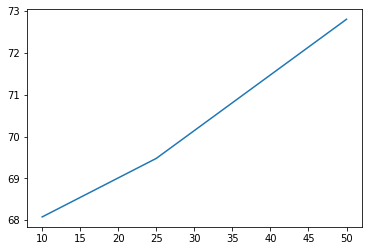

In [14]:
n_components = [10, 25, 50]
scores = []
for n in n_components:
    gmm_landsat = GaussianMixture(n_components=n, init_params='random', covariance_type='full')
    gmm_landsat = gmm_landsat.fit(data_sat)
    scores.append(gmm_landsat.score(data_sat))

plt.plot(n_components, scores)
plt.show()

In [ ]:
init_scale_range = [0.01, 0.0005]
n_comp = [10]
ampl_list = [0.1]

# recipe for experiments: EM inti iter =100, high ampl (lr), 100 pso iters, compare with EM init 200 iter
# note: low lr for big number of components, try rank = 3, 5, 7
# Add best EM init with zero addition
# add an csv logging
# fix a bug with global best
rank = 5
n_runs = 5
init_scale = 0.01
init_scale = 0.05

ampl = 0.1

g_best_reinit_list = []
basic_score_list = []
for n in range(n_runs):
    log_file_name = f'landsat_low_rank_parametrize_init_scale_{init_scale}_n_comp_{10}_ampl_{ampl}_rank_{rank}.log'
    pso_best_loglikelihood, best_loglikelihood_init, large_gmm_init_score, particle_trajectories, g_best_reinit, basic_score = run_experiment_delta_parametrize(cloud_data, log_file_name, n_components=10, amplitude=ampl, rank=rank, init_scale=init_scale)
    g_best_reinit_list.append(g_best_reinit)
    basic_score_list.append(basic_score)
    final_score = pso_best_loglikelihood[-1]

print('Best scattered reinit', np.mean(g_best_reinit_list), '+-' , np.std(g_best_reinit_list))
print('Best EM init', np.mean(basic_score_list), '+-' , np.std(basic_score_list))
